In [ ]:
#prepare for data training

In [1]:


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from sklearn.cluster import KMeans
from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16


print(os.listdir("images2/"))

#Resizing images is optional
SIZE_X = 1024 
SIZE_Y = 996

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("images2/train_images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)      
train_images = np.array(train_images)


train_masks = [] 
for directory_path in glob.glob("images2/train_masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

#Use customary x_train and y_train variables
X_train = train_images
y_train = train_masks
y_train = np.expand_dims(y_train, axis=3) 




['.DS_Store', 'Train_images', 'Train_masks']


In [2]:
train_masks.size


1019904

In [3]:
import pandas as pd
import pickle
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import os

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 996, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1024, 996, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1024, 996, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 512, 498, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 512, 498, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 512, 498, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 256, 249, 128)     0     

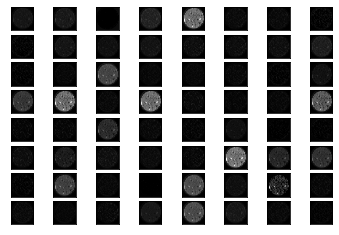

[ 33 201 231  65]
33     491532
231    439024
201     72927
65      16421
Name: Label, dtype: int64


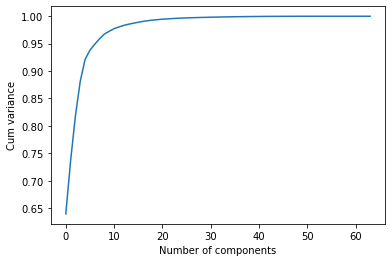

In [4]:
#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)

#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

#Reshape Y to match X
Y = y_train.reshape(-1)

#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
dataset = dataset[dataset['Label'] != 0]

#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']
#PCA for randomforest test
from sklearn.decomposition import PCA
pca_test = PCA(n_components=64) #
pca_test.fit(X_for_RF)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")
#data with pca 
pca = PCA(n_components=5) 
train_PCA = pca.fit_transform(X_for_RF)



In [38]:
from sklearn.cluster import KMeans
from skimage.io import imsave, imshow


In [70]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
model.fit(train_PCA, Y_for_RF) 

#Save model for future use
filename = 'RF_model.sav'
pickle.dump(model, open(filename, 'wb'))
prediction = model.predict(train_PCA)
print(confusion_matrix(Y_for_RF,prediction))
print(classification_report(Y_for_RF,prediction))


[[491526      0      3      3]
 [     0  16421      0      0]
 [    21      0  72871     35]
 [     0      2     17 439005]]
              precision    recall  f1-score   support

          33       1.00      1.00      1.00    491532
          65       1.00      1.00      1.00     16421
         201       1.00      1.00      1.00     72927
         231       1.00      1.00      1.00    439024

    accuracy                           1.00   1019904
   macro avg       1.00      1.00      1.00   1019904
weighted avg       1.00      1.00      1.00   1019904



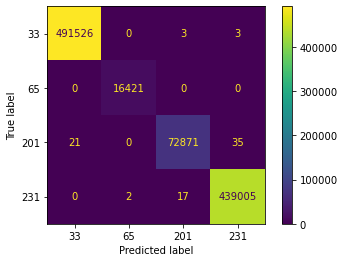

In [72]:
plot_confusion_matrix(model,train_PCA, Y_for_RF)
plt.show()

In [74]:
#investigate wich model is the best choice to proceed final resuilt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
svc = SVC()
knn = KNeighborsClassifier()
ls = LogisticRegression()
svc.fit(train_PCA, Y_for_RF)
knn.fit(train_PCA, Y_for_RF)



KNeighborsClassifier()

[[487353     24   2962   1193]
 [    15  16108      0    298]
 [  4424     36  56636  11831]
 [  1356    201   4756 432711]]
              precision    recall  f1-score   support

          33       0.99      0.99      0.99    491532
          65       0.98      0.98      0.98     16421
         201       0.88      0.78      0.83     72927
         231       0.97      0.99      0.98    439024

    accuracy                           0.97   1019904
   macro avg       0.96      0.93      0.94   1019904
weighted avg       0.97      0.97      0.97   1019904



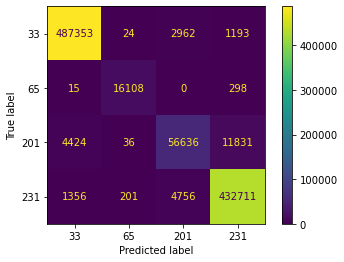

[[487946     21   2658    907]
 [    15  16125      4    277]
 [  3690     41  59928   9268]
 [  1257    171   4638 432958]]
              precision    recall  f1-score   support

          33       0.99      0.99      0.99    491532
          65       0.99      0.98      0.98     16421
         201       0.89      0.82      0.86     72927
         231       0.98      0.99      0.98    439024

    accuracy                           0.98   1019904
   macro avg       0.96      0.95      0.95   1019904
weighted avg       0.98      0.98      0.98   1019904



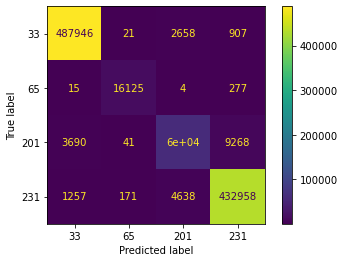

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [75]:
# get parameter fo choice
zz = [svc,knn,ls]

for model in zz:
    prediction = model.predict(train_PCA)
    print(confusion_matrix(Y_for_RF,prediction))
    print(classification_report(Y_for_RF,prediction))
    plot_confusion_matrix(model,train_PCA, Y_for_RF)
    plt.show()

In [31]:
#tuning model with different params to find out with params is the best to work for final resuilt 
loaded_model = pickle.load(open(filename, 'rb'))
from sklearn.model_selection import RandomizedSearchCV
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 100, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(10, 100, 10, dtype = int))}
clf = RandomForestClassifier()
model_turn = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model_turn.fit(train_PCA, Y_for_RF)




Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed: 107.9min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 138.3min finished


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=80,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 6, 8, 12],
                                        'min_samples_split': [5, 7, 10, 14],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=101, verbose=5)

In [68]:
predictionforest = model_turn.best_estimator_.predict(train_PCA)
print(confusion_matrix(Y_for_RF,predictionforest))
print(classification_report(Y_for_RF,predictionforest))

[[488866     15   1850    801]
 [     7  16172      0    242]
 [  2782     36  62251   7858]
 [   889    125   2979 435031]]
              precision    recall  f1-score   support

          33       0.99      0.99      0.99    491532
          65       0.99      0.98      0.99     16421
         201       0.93      0.85      0.89     72927
         231       0.98      0.99      0.99    439024

    accuracy                           0.98   1019904
   macro avg       0.97      0.96      0.96   1019904
weighted avg       0.98      0.98      0.98   1019904



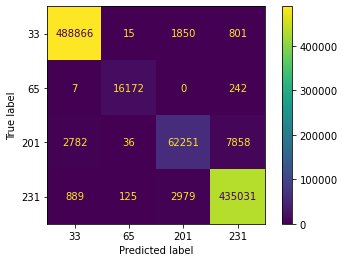

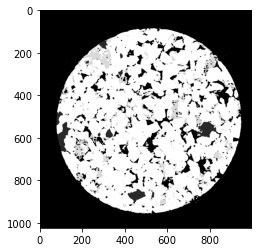

In [41]:
#test model to evaluate the accuracy of the training model
from sklearn.metrics import plot_confusion_matrix
pickle.dump(model, open("model_turning.sav", 'wb'))
#loaded_model_tuning = pickle.load(open("model_turning.sav", 'rb'))

plot_confusion_matrix(model_turn,train_PCA, Y_for_RF)
plt.show()
prediction_image = predictionforest.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
#plt.imsave('images/test_images/360_segmented.jpg', prediction_image, cmap='gray')
plt.show()



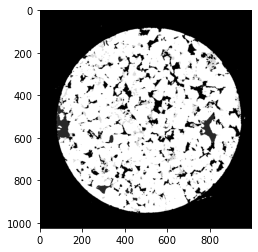

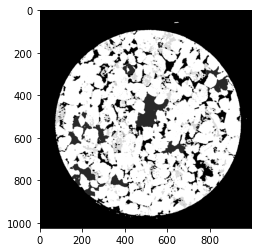

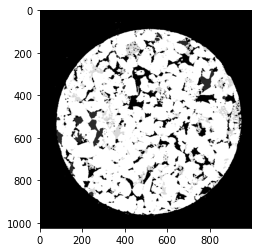

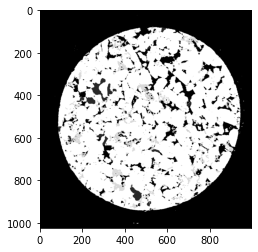

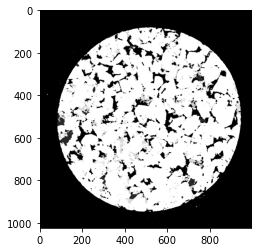

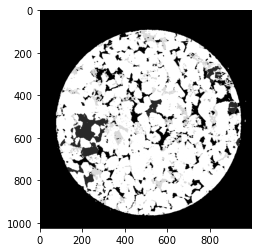

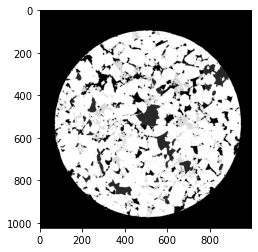

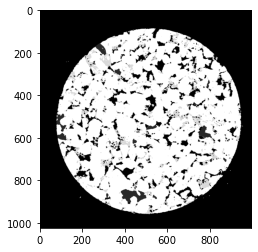

In [51]:
# proceed apply model for entire data(images)
train_images_ = []
for directory_path in glob.glob("images2/Train_images/backup"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        features_=new_model.predict(np.array([img]))
        X = features_.reshape(-1, features_.shape[3])
        train_PCA_ = pca.fit_transform(X)
        predictionforest_ = model_turn.best_estimator_.predict(train_PCA_)
        prediction_image_ = predictionforest_.reshape(mask.shape)
        plt.imshow(prediction_image_, cmap='gray')
        imsave("images2/Train_images/Test"+ img_path.split("/")[-1],prediction_image_)
        plt.show()

In [15]:
print(np.unique(truth), np.unique(prediction_))

[ 33  65 201 231] [ 33  65 201 231]
